# Supervised Learning Classification: INN Hotels Project

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations. 

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics. 

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Objective
The increasing number of cancellations calls for a Machine Learning based solution that can help in predicting which booking is likely to be canceled. INN Hotels Group has a chain of hotels in Portugal, they are facing problems with the high number of booking cancellations and have reached out to your firm for data-driven solutions. You as a data scientist have to analyze the data provided to find which factors have a high influence on booking cancellations, build a predictive model that can predict which booking is going to be canceled in advance, and help in formulating profitable policies for cancellations and refunds.

## Data Description
The data contains the different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

## Importing necessary libraries, data, and creating functions

In [1]:
# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# To build Logistic Regression model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer
)

# Libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV

In [2]:
#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

In [3]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [4]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="aqua"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [5]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [6]:
# defining a function to plot the confusion_matrix of a classification model

def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=labels, fmt="", cmap='viridis')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [7]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap='viridis')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [8]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=labels,fmt='',cmap='viridis')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
##  Function to calculate f1 score
def get_f1_score(model, predictors, target):
    """
    model: classifier
    predictors: independent variables
    target: dependent variable
    
    """
    prediction = model.predict(predictors)
    return f1_score(target, prediction)

In [10]:
#import csv into dataframe
hotel = pd.read_csv("INNHotelsGroup.csv")

In [11]:
# copying data to another varaible to avoid any changes to original data
df = hotel.copy()

## Data Overview

In [12]:
#show first five rows of data
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [13]:
#show a random sample of five rows of data
df.sample(n=5)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
30048,INN30049,2,0,1,2,Not Selected,0,Room_Type 1,80,2018,3,25,Online,0,0,0,85.50,0,Canceled
21003,INN21004,2,0,0,3,Meal Plan 1,0,Room_Type 4,103,2018,9,8,Online,0,0,0,149.40,0,Canceled
23749,INN23750,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Offline,0,0,0,115.00,1,Canceled
30908,INN30909,1,0,0,3,Not Selected,0,Room_Type 1,77,2018,6,16,Online,0,0,0,125.10,0,Canceled
9276,INN09277,1,0,2,2,Meal Plan 1,0,Room_Type 4,86,2018,11,6,Online,0,0,0,146.60,1,Canceled


In [14]:
df.shape

(36275, 19)

#### Observations

- The dataframe has 36275 rows and 19 columns.

## Data Preprocessing

In [15]:
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df.drop(labels='no_of_weekend_nights', axis=1, inplace=True)
df.drop(labels='no_of_week_nights', axis=1, inplace=True)

In [16]:
#checking for duplicate values
df[df.duplicated()].count()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
total_nights                            0
dtype: int64

In [17]:
#check for missing values
df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
total_nights                            0
dtype: int64

#### Observations
- There are no duplicate values in the dataset.
- There appears to be no missing data across all columns.

### Variable data types and conversions

In [18]:
#observe the data types of the columns for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   type_of_meal_plan                     36275 non-null  object 
 4   required_car_parking_space            36275 non-null  int64  
 5   room_type_reserved                    36275 non-null  object 
 6   lead_time                             36275 non-null  int64  
 7   arrival_year                          36275 non-null  int64  
 8   arrival_month                         36275 non-null  int64  
 9   arrival_date                          36275 non-null  int64  
 10  market_segment_type                   36275 non-null  object 
 11  repeated_guest 

#### Observations
- There are 5 columns of the dtype object, 1 columns of the dtype float64, and 13 columns of the dtype int64.
- The target variable for both the Logistic Regression model and the Decision Tree model will be *booking_status*.
- room_type_reserved values are ciphered (encoded) by INN Hotels and will not be useful for model building.
- Booking_ID values should also not provide any material information for model building.

In [19]:
#drop the column *Booking_ID* and *room_type_reserved* from the dataframe
df.drop(labels='Booking_ID', axis=1, inplace=True)
df.drop(labels='room_type_reserved', axis=1, inplace=True)

- All columns with object dtype object should be converted to category, which will reduce the space required to store the DataFrame and help with analysis later on.

In [20]:
#convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [21]:
#confirm conversions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   type_of_meal_plan                     36275 non-null  category
 3   required_car_parking_space            36275 non-null  int64   
 4   lead_time                             36275 non-null  int64   
 5   arrival_year                          36275 non-null  int64   
 6   arrival_month                         36275 non-null  int64   
 7   arrival_date                          36275 non-null  int64   
 8   market_segment_type                   36275 non-null  category
 9   repeated_guest                        36275 non-null  int64   
 10  no_of_previous_cancellations          36275 non-null  int64   
 11  no

## Exploratory Data Analysis (EDA)

#### INN Hotels Group requested answers for the following questions:
1. What are the busiest months in the hotel?
2. Which market segment do most of the guests come from?
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
4. What percentage of bookings are canceled? 
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

#### What are the busiest months in the hotel?

In [22]:
#group by *arrival month*, count number of records per month, sort from most to fewest bookings, and show top 3 months
df.groupby('arrival_month').count().sort_values(by='booking_status', ascending=False)['booking_status'].head(3)

arrival_month
10    5317
9     4611
8     3813
Name: booking_status, dtype: int64

- The month of October is the busiest month for the hotel, followed by September and August.

#### Which market segment do most of the guests come from?

In [23]:
df.groupby('market_segment_type').count().sort_values(by='booking_status', ascending=False)['booking_status']

market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: booking_status, dtype: int64

- 23214 (~64%) of the 36275 total bookings are made online.

#### What are the differences in room prices in different market segments?

In [24]:
df.groupby('market_segment_type').agg({'avg_price_per_room':'mean'}).sort_values(by='avg_price_per_room',ascending=False).reset_index()

,market_segment_type,avg_price_per_room
0,Online,112.26
1,Aviation,100.70
2,Offline,91.63
3,Corporate,82.91
4,Complementary,3.14


- Online bookings yield the highest average price per room ($112.25), followed by bookings through Aviation and Offline market segments.

#### What percentage of bookings are canceled? 

In [25]:
df['booking_status'].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

- 11885 (~33%) of the total 36275 bookings were cancelled.

#### What percentage of repeating guests cancel?

In [26]:
df.groupby('repeated_guest')['booking_status'].value_counts()

repeated_guest  booking_status
0               Not_Canceled      23476
                Canceled          11869
1               Not_Canceled        914
                Canceled             16
Name: booking_status, dtype: int64

- Only 16 (~2%) of the 930 total bookings made by repeated guest were cancelled.

#### Do special requirements affect booking cancellation?

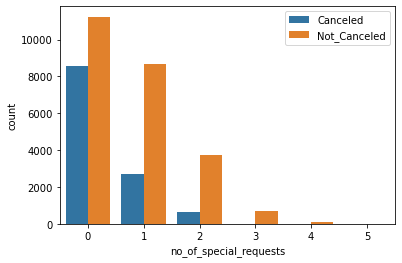

In [27]:
sns.countplot(data=df, hue='booking_status', x='no_of_special_requests')
plt.legend(loc='upper right')
plt.show()

- As the number of special requests made by customers increase, the proportion of bookings cancelled decreases.

## Univariate Analysis

### Summary of float64 variables

In [28]:
#provide summary statistics of all float64 variables
df.describe(include = ['float64']).T

,count,mean,std,min,25%,50%,75%,max
avg_price_per_room,36275.00,103.42,35.09,0.00,80.30,99.45,120.00,540.00


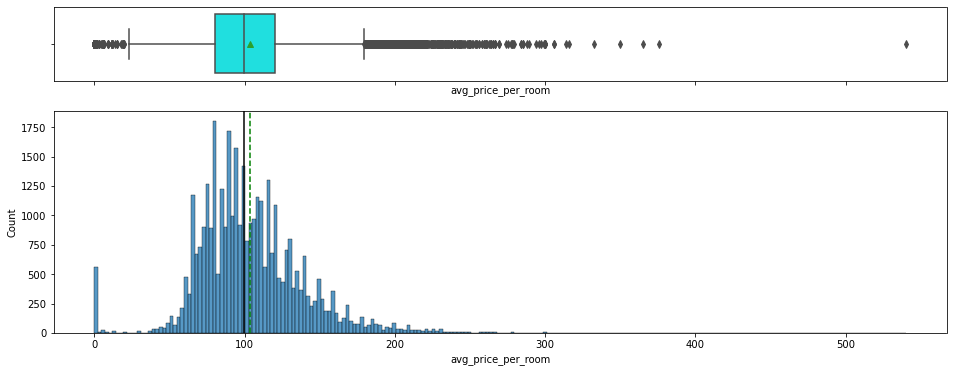

In [29]:
#provide histogram and boxplot for average room price
histogram_boxplot(df,'avg_price_per_room')

#### Observations
- The median average room price is ~100 euros per night.
- The distribution of average room prices is skewed right, showing a significant influence of highly priced rooms.

### Summary of int64 variables

In [30]:
#provide summary statistics of all float64 variables
df.describe(include = ['int64']).T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.00,1.84,0.52,0.00,2.00,2.00,2.00,4.00
no_of_children,36275.00,0.11,0.40,0.00,0.00,0.00,0.00,10.00
required_car_parking_space,36275.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
lead_time,36275.00,85.23,85.93,0.00,17.00,57.00,126.00,443.00
arrival_year,36275.00,2017.82,0.38,2017.00,2018.00,2018.00,2018.00,2018.00
arrival_month,36275.00,7.42,3.07,1.00,5.00,8.00,10.00,12.00
arrival_date,36275.00,15.60,8.74,1.00,8.00,16.00,23.00,31.00
repeated_guest,36275.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
no_of_previous_cancellations,36275.00,0.02,0.37,0.00,0.00,0.00,0.00,13.00
no_of_previous_bookings_not_canceled,36275.00,0.15,1.75,0.00,0.00,0.00,0.00,58.00


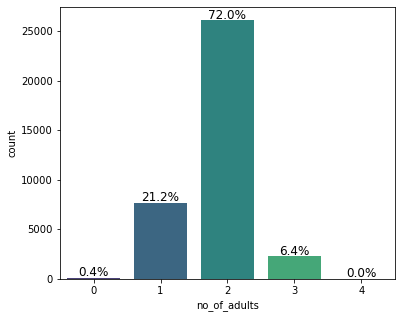

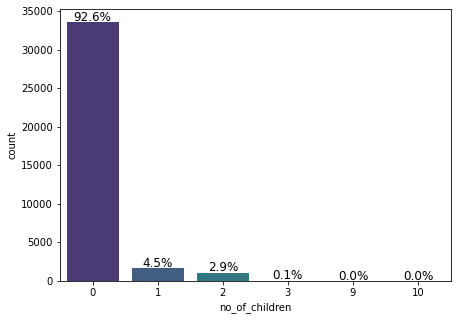

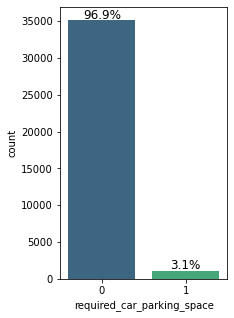

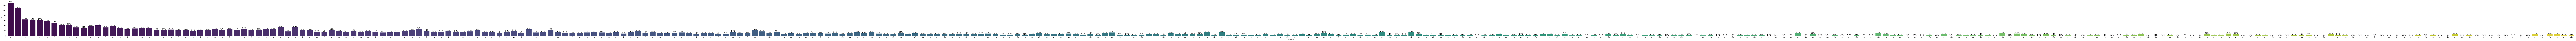

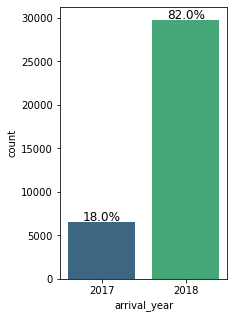

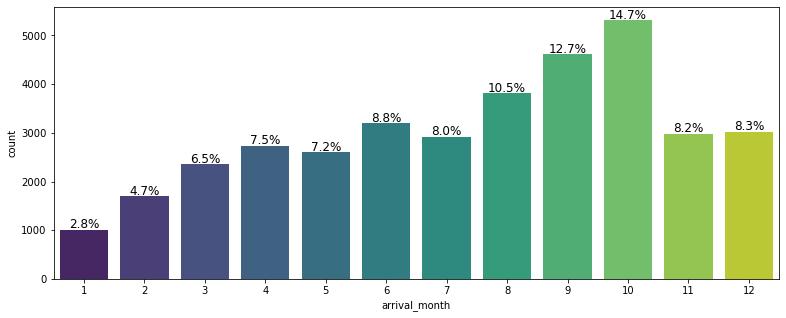

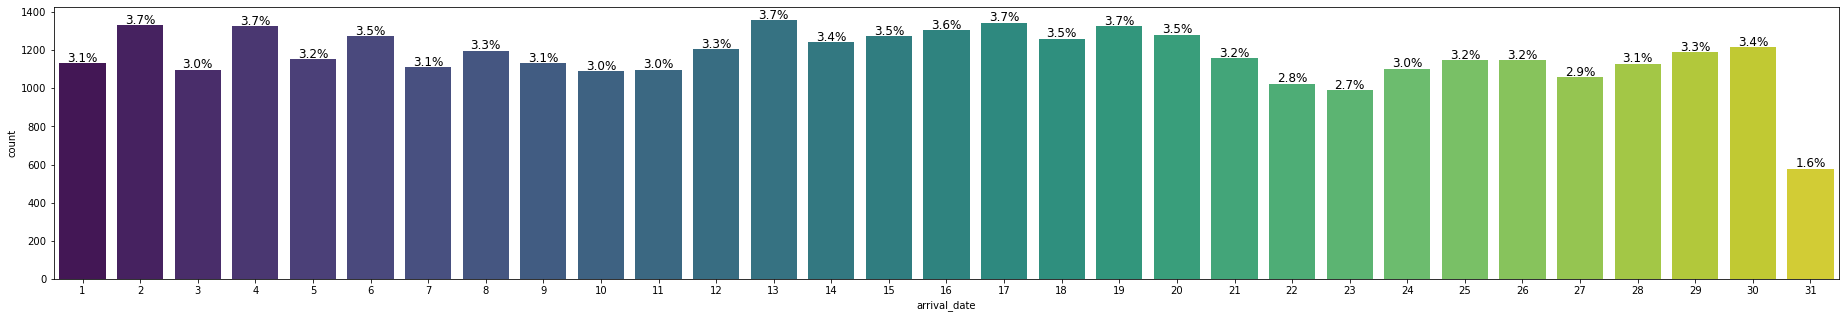

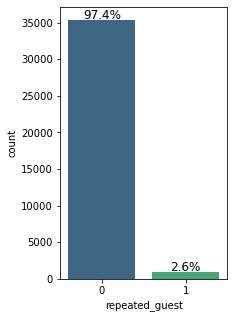

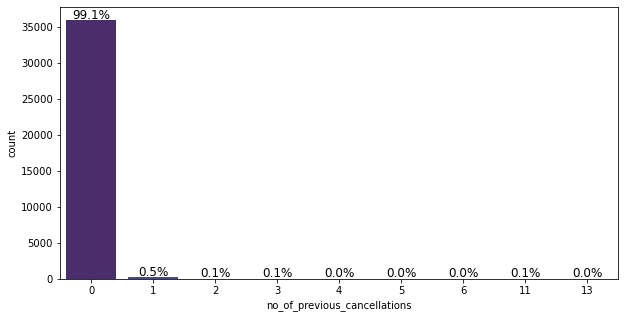

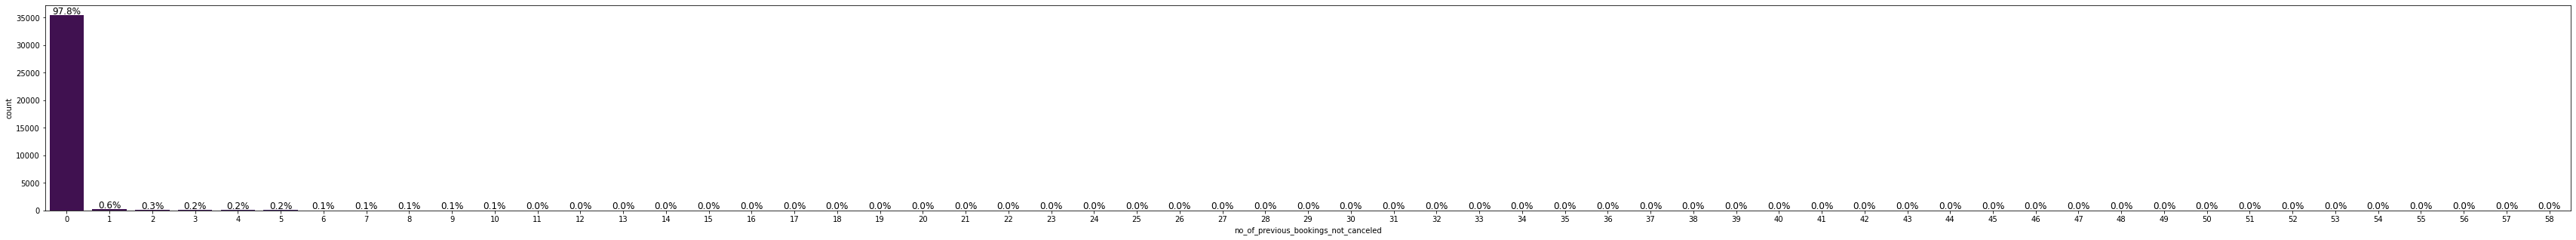

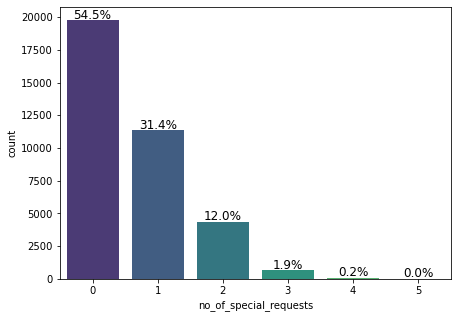

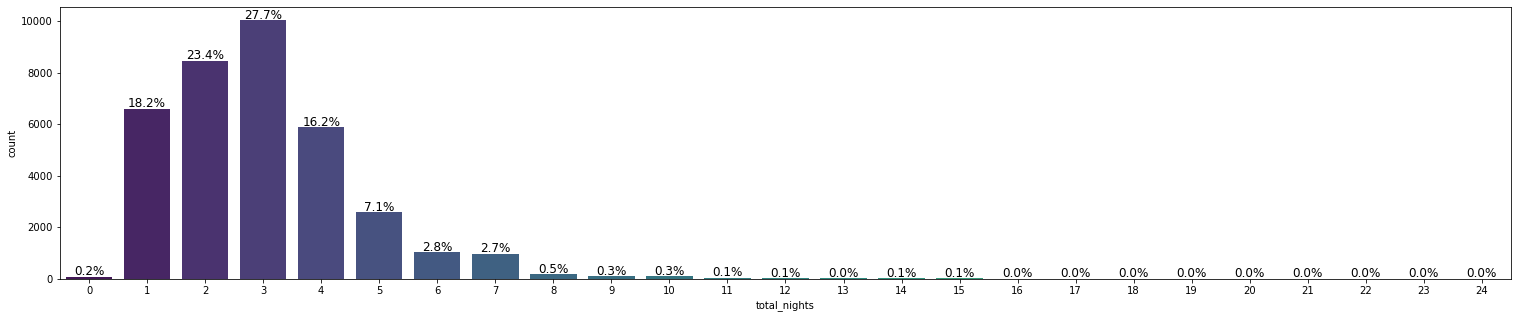

In [31]:
#provide boxplots of int64 variables
for col in df.columns[df.dtypes == 'int64']:
    labeled_barplot(df, col, perc=True)

In [32]:
df[df.no_of_previous_cancellations!=0]['no_of_previous_cancellations'].count()

338

#### Observations
- 78% of the bookings included two or more adults, indicative of a couple or family traveling for pleasure, and 21% of bookings were for a single adult, indicative of a businessperson travelling for work.
- ~93% of bookings included no children.
- ~97% of guests did not require a parking space and not a single booking required more than one space.
- 82% of the bookings in the dataset occured during 2018.
- Only 2.6% of bookings were from repeat guests.
- 0.9% of bookings (338 out of 36,275 total bookings) were booked by a guest with one or more previous cancellations on record.

### Summary of categorical variables

In [33]:
#provide descriptive statistics for categorical variables
df.describe(include = ['category']).T

,count,unique,top,freq
type_of_meal_plan,36275,4,Meal Plan 1,27835
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


In [34]:
#provide counts for each unique variable in each categorical variable
for colname in df.dtypes[df.dtypes == 'category'].index:
    print(df[colname].value_counts(dropna=False))
    print(" ")

Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64
 
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64
 
Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64
 


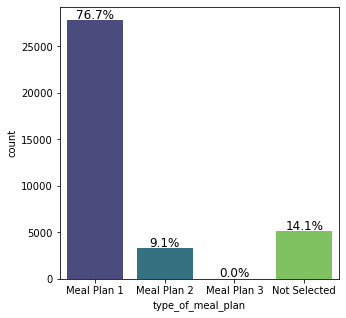

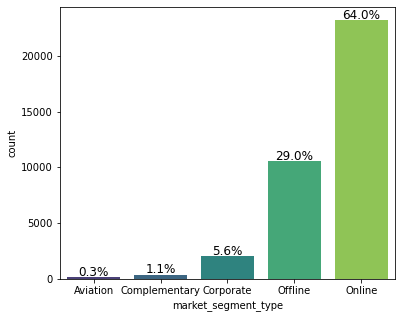

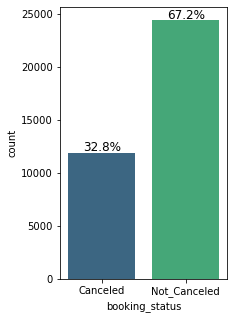

In [35]:
#provide boxplots of categorical variables
for col in df.columns[df.dtypes == 'category']:
    labeled_barplot(df, col, perc=True)

#### Observations
- 32.8% of all bookings were cancelled.
- 64% of all bookings were booked online.
- More than 90% of bookings chose to receive only breakfast or no meal at all.

## Bivariate Analysis

#### Correlation heat map

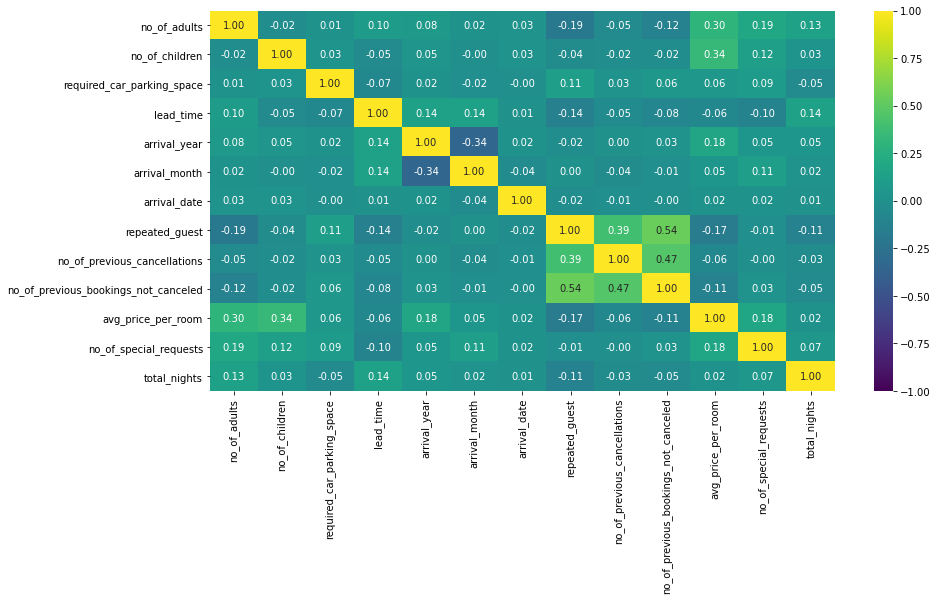

In [36]:
#create correlation heat map for numerical variables
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

# correlation heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    df[numeric_columns].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap='viridis'
)
plt.show()

#### Observations
- Most of the variables shows no or essentially useless correlations.
- As the number of adults and children increase, the average price of a room can weakly be expected to increase.
- If a guest is a repeat guest, they are weakly more likely to have both previously cancelled and not cancelled a booking:
    * A repeat guest has more opportunities to decide to cancel or not cancel these previous bookings. 
    * The weak positive correlation between number of previous cancellations and number of previous bookings not cancelled supports this conclusion.

In [37]:
#calculate interquartile range for average room price
IQR = (120-80.30)

In [38]:
#create dataframes of rooms sold for no price, rooms sold for a low outlier average room price, and rooms sold for a high outlier average room price
df_0 = df[df.avg_price_per_room == 0]
df_low = df[df.avg_price_per_room < 99.45-1.5*IQR]
df_high = df[df.avg_price_per_room > 99.45+1.5*IQR]

In [39]:
for colname in df_0.dtypes[df.dtypes == 'category'].index:
    print(df_0[colname].value_counts(dropna=False))
    print(" ")

Meal Plan 1     450
Meal Plan 2      59
Not Selected     32
Meal Plan 3       4
Name: type_of_meal_plan, dtype: int64
 
Complementary    354
Online           191
Aviation           0
Corporate          0
Offline            0
Name: market_segment_type, dtype: int64
 
Not_Canceled    539
Canceled          6
Name: booking_status, dtype: int64
 


In [40]:
for colname in df_low.dtypes[df.dtypes == 'category'].index:
    print(df_low[colname].value_counts(dropna=False))
    print(" ")

Meal Plan 1     577
Meal Plan 2      73
Not Selected     32
Meal Plan 3       4
Name: type_of_meal_plan, dtype: int64
 
Complementary    378
Online           246
Offline           53
Corporate          9
Aviation           0
Name: market_segment_type, dtype: int64
 
Not_Canceled    665
Canceled         21
Name: booking_status, dtype: int64
 


In [41]:
for colname in df_high.dtypes[df.dtypes == 'category'].index:
    print(df_high[colname].value_counts(dropna=False))
    print(" ")

Meal Plan 1     1886
Meal Plan 2      362
Not Selected      52
Meal Plan 3        1
Name: type_of_meal_plan, dtype: int64
 
Online           2111
Offline           154
Corporate          35
Complementary       1
Aviation            0
Name: market_segment_type, dtype: int64
 
Not_Canceled    1454
Canceled         847
Name: booking_status, dtype: int64
 


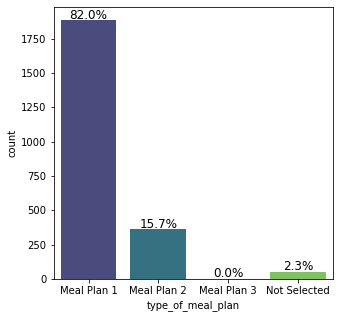

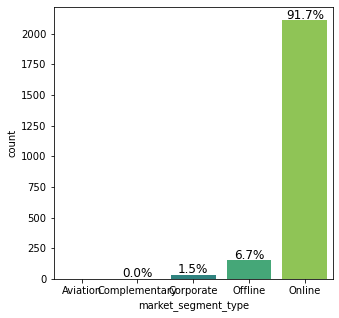

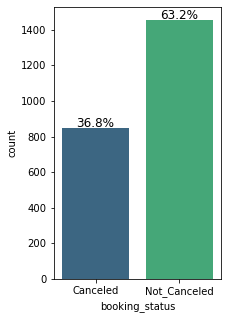

In [42]:
#provide boxplots of categorical variables for bookings with high outlier prices
for col in df_high.columns[df_high.dtypes == 'category']:
    labeled_barplot(df_high, col, perc=True)

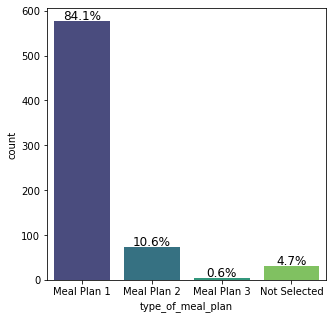

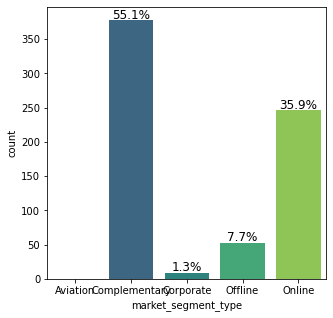

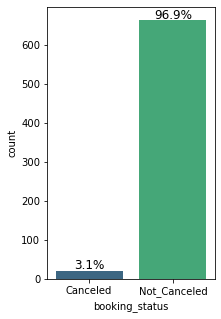

In [43]:
#provide boxplots of categorical variables for bookings with low outlier prices
for col in df_low.columns[df_low.dtypes == 'category']:
    labeled_barplot(df_low, col, perc=True)

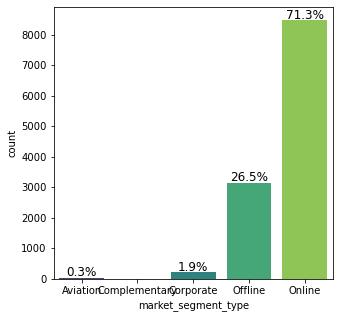

In [44]:
#create a dataframe of only cancelled bookings
df_canc = df[df.booking_status=='Canceled']
#create a barplot of the market segments of cancelled bookings
labeled_barplot(df_canc, 'market_segment_type',perc=True)

In [45]:
#provide summary statistics of the average price of a room which had a cancelled booking
df_canc.describe(include = ['float64']).T

,count,mean,std,min,25%,50%,75%,max
avg_price_per_room,11885.00,110.59,32.26,0.00,89.27,108.00,126.36,540.00


#### Observations
- 565 rooms were sold at no (i.e., 0) cost to the guests during the period observed.
- Of the rooms with low outlier average room prices (<~40 euros/night):
    - **Only 3% of these guests cancelled reservations**
- Of the rooms with high outlier average room prices (>~160 euros/night):
    - More than a third (~36%) cancelled reservations, 4% higher than the cancelation rate for all bookings.
    - Over 91% of these high-priced reservations were booked online.
- 71.3% of cancelled bookings were booked online.

# Logistic Regression models

#### Encoding Not Canceled as 0 and Canceled as 1, as the hotel wants to identify those customers predicted to cancel their booking

In [46]:
df["booking_status"] = df["booking_status"].apply(lambda x: 1 if x == "Canceled" else 0)

## Spliting the data 
We will use 70% of data for training and 30% for testing.

In [47]:
X = df.drop('booking_status',axis=1)     # Predictor feature columns (8 X m)
Y = df['booking_status']   # Predicted class (1=True, 0=False) (1 X m)

X = pd.get_dummies(X, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
# 1 is just any random seed number

x_train.head()

,no_of_adults,no_of_children,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,total_nights,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
13662,1,0,0,163,2018,10,15,0,0,0,115.00,0,1,0,0,0,0,0,1,0
26641,2,0,0,113,2018,3,31,0,0,0,78.15,1,3,0,0,0,0,0,0,1
17835,2,0,0,359,2018,10,14,0,0,0,78.00,1,5,0,0,0,0,0,1,0
21485,2,0,0,136,2018,6,29,0,0,0,85.50,0,3,0,0,1,0,0,0,1
5670,2,0,0,21,2018,8,15,0,0,0,151.00,0,3,0,0,0,0,0,0,1


In [48]:
y_train.head()

13662    1
26641    0
17835    0
21485    1
5670     1
Name: booking_status, dtype: category
Categories (2, int64): [1, 0]

In [49]:
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [50]:
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (25392, 20)
Shape of test set :  (10883, 20)
 
Percentage of classes in training set:
0   0.67
1   0.33
Name: booking_status, dtype: float64
 
Percentage of classes in test set:
0   0.68
1   0.32
Name: booking_status, dtype: float64


## Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting a person booking a room will cancel, but they do not.
2. Predicting a person booking a room will not cancel, but they do.

### Which case is more important? 
* Both are important:

    * If we predict a person will cancel and then they do not, then we will reallocate their room to another guest and not have a room available to them upon their arrival, costing the hotel a significant amount of money (by offering them a complimentary upgraded room), likely losing a repeat customer(s), and generating negative review(s) for the hotel.

    * If we predict a person will not cancel their reservation and then they do, we will lose out on the revenue generated from their reservation, have to incur the costs of remarketing the room, and more than likely rebook the room at a discount.

### How to reduce these costs i.e maximize True Positives?
*  **F1 score** should be maximized, the greater the f1_score higher the chances of identifying both the classes correctly.

##  Building the Logistic Regression model (with Sklearn library)

In [51]:
lg = LogisticRegression(solver="liblinear", random_state=1)
model = lg.fit(x_train, y_train)

#### Checking model performance on training set

In [52]:
# predicting on training set
y_pred_train = lg.predict(x_train)

In [53]:
print("Training set performance:")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall:", recall_score(y_train, y_pred_train))
print("F1:", f1_score(y_train, y_pred_train))

Training set performance:
Accuracy: 0.8010790800252048
Precision: 0.7361665715915573
Recall: 0.6172426162860217
F1: 0.6714796747967481


#### Checking performance on test set

In [54]:
# predicting on the test set
y_pred_test = lg.predict(x_test)

In [55]:
print("Test set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

Test set performance:
Accuracy: 0.8036387025636313
Precision: 0.7310643977310644
Recall: 0.6220897217490062
F1: 0.6721889860408037


**Observations**
- The training and testing precision rates are ~0.73.
- The f1_score on the train and test sets are comparable, which indicates that the model is showing generalized results.

## Building the Logistic Regression model (with statsmodels library)

In [56]:
X = df.drop(["booking_status"], axis=1)
Y = df["booking_status"]

X = pd.get_dummies(X, drop_first=True)

# adding constant
X = sm.add_constant(X)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

In [57]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# fitting logistic regression model
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25371
Method:                           MLE   Df Model:                           20
Date:                Fri, 19 Nov 2021   Pseudo R-squ.:                  0.3266
Time:                        09:25:42   Log-Likelihood:                -10836.
converged:                      False   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -947.8054    120.138     -7.889      0.000   -1183.271    -712.340
no_of_adults                             0.0698      

In [58]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.63,0.74,0.68


**Observations**

- Negative values of the coefficient shows that the probability of a hotel booking being cancelled decreases with the increase of corresponding attribute value.

- Positive values of the coefficient show that that probability of a hotel booking being cancelled increases with the increase of corresponding attribute value.

- p-value of a variable indicates if the variable is significant or not. If we consider the significance level to be 0.05 (5%), then any variable with a p-value less than 0.05 would be considered significant. However, these variables might contain multicollinearity, which will affect the p-values.

- We will have to remove multicollinearity from the data to get reliable coefficients and p-values.

## Checking Multicollinearity

- In order to make statistical inferences from a logistic regression model, we must ensure that multicollinearity is not present in the data.
* **VIF standards**:
    - If VIF is between 1 and 5, then there is low multicollinearity.
    - If VIF is between 5 and 10, we say there is moderate multicollinearity.
    - If VIF is exceeding 10, it shows signs of high multicollinearity.

In [59]:
# defining a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]
    return vif

In [60]:
checking_vif(X_train).sort_values(by='VIF', ascending=False)

,feature,VIF
0,const,39091160.37
20,market_segment_type_Online,70.87
19,market_segment_type_Offline,63.67
18,market_segment_type_Corporate,16.82
17,market_segment_type_Complementary,4.44
8,repeated_guest,1.78
11,avg_price_per_room,1.75
10,no_of_previous_bookings_not_canceled,1.65
5,arrival_year,1.42
9,no_of_previous_cancellations,1.39


- Excluding the dummy variables, no other predictor variables show a VIF above 5

**The above predictors have no multicollinearity and the assumption is satisfied.**

**Observations**

- As there is no multicollinearity, we can look at the p-values of predictor variables to check their significance.
- Of the 20 variables in this logistic regression model, 7 of these predictor variables are shown to be statistically insignificant.
- However, sometimes p-values change after dropping a variable, so I will do the following:
    - Build a model, check the p-values of the variables, and drop the column with the highest p-value.
    - Create a new model without the dropped feature, check the p-values of the variables, and drop the column with the highest p-value.
    - Repeat the above two steps till there are no columns with p-value > 0.05.

In [61]:
# running a loop to drop variables with high p-value

# initial list of columns
cols = X_train.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    X_train_aux = X_train[cols]

    # fitting the model
    model = sm.Logit(y_train, X_train_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'no_of_adults', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'repeated_guest', 'no_of_previous_cancellations', 'avg_price_per_room', 'no_of_special_requests', 'total_nights', 'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Not Selected', 'market_segment_type_Corporate', 'market_segment_type_Offline']


In [62]:
X_train2 = X_train[selected_features]

In [63]:
logit2 = sm.Logit(y_train, X_train2.astype(float))
lg2 = logit2.fit(disp=False)
print(lg2.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25377
Method:                           MLE   Df Model:                           14
Date:                Fri, 19 Nov 2021   Pseudo R-squ.:                  0.3254
Time:                        09:25:44   Log-Likelihood:                -10855.
converged:                       True   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -945.1028    119.540     -7.906      0.000   -1179.397    -710.809
no_of_adults                       0.0736      0.036      2.068      0.

**Now no feature has p-value greater than 0.05, so we'll consider the features in *X_train2* as the final ones and *lg2* as final model.**

### Coefficient interpretations

* Coefficients for the number of adults, the lead time prior to a booking, the arrival year (i.e., 2018 v. 2017), the number of previous cancellations, the average room price, the total nights booked, selecting Meal Plan 2, and not selecting a meal plan are all positive, meaning an increase in these will lead to increase in chances of a hotel booking being cancelled.

* Coefficients for requiring a parking space, arrival month, being a repeat guest, the number of special requests, and the market segments for Corporate and Offline are all negative, meaning an increase in these will lead to decrease in chances of a hotel booking being cancelled.

###  Converting coefficients to odds
* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [64]:
# converting coefficients to odds
odds = np.exp(lg2.params)

# finding the percentage change
perc_change_odds = (np.exp(lg2.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odds": perc_change_odds}, index=X_train2.columns).sort_values(by='Change_odds')

,Odds,Change_odds
const,0.00,-100.00
repeated_guest,0.06,-93.90
market_segment_type_Offline,0.17,-82.71
required_car_parking_space,0.20,-79.61
no_of_special_requests,0.23,-76.72
market_segment_type_Corporate,0.44,-55.58
arrival_month,0.96,-3.90
lead_time,1.02,1.57
avg_price_per_room,1.02,1.65
total_nights,1.06,5.65


### Coefficient interpretations

* *repeated_guest*: Holding all other features constant, a unit change in repeated_guest (i.e., a person booking the room being a repeated guest) decreases the odds that booking being canceled by 0.06 times or a **94%** decrease in odds of a booking being canceled.
* *market_segment_type_Offline*: Holding all other features constant, a unit change in market_segment_type_Offline (i.e., a booking originating from the Offline market segment) decreases the odds that booking being canceled by 0.17 times or an **83%** decrease in odds of a booking being canceled.
* Similarly, other coefficients include:
    * A guest requiring a parking space decreases the odds of that booking being canceled by 0.20 times or an **80%** decrease in odds of a booking being canceled.
    * A single additional euro increase in the average cost per night increases the odds of that booking being canceled by 1.02 times or a **2%** increase in the odds of a booking being canceled.
    * A single additional night booked at the hotel increases the odds of that booking being canceled by 1.96 times or a **6%** increase in the odds of a booking being canceled.

*Interpretation for other attributes can be done similarly.*

## Logistic Regression model performance evaluation

#### Checking model performance on the training set

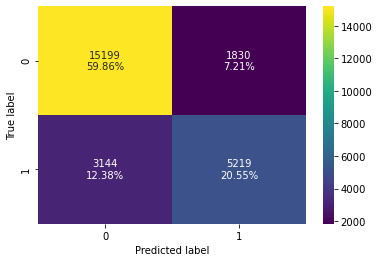

In [65]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_train2, y_train)

In [66]:
log_reg_model_train_perf = model_performance_classification_statsmodels(lg2, X_train2, y_train)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.62,0.74,0.68


#### ROC-AUC (Training)

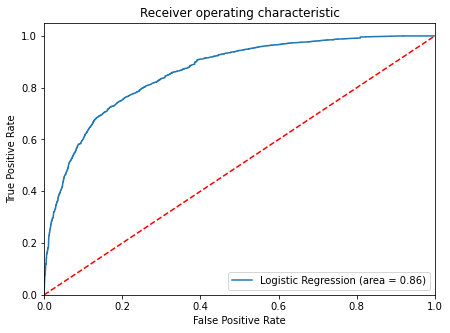

In [67]:
logit_roc_auc_train = roc_auc_score(y_train, lg2.predict(X_train2))
fpr, tpr, thresholds = roc_curve(y_train, lg2.predict(X_train2))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

* This model is performing well on the training set.

### Optimize Model Performance

* We can now investigate improving the precision score by changing the model threshold using AUC-ROC Curve.

### Optimal threshold using AUC-ROC curve

In [68]:
# Optimal threshold as per AUC-ROC curve
# This threshold occurs where the true positive rate (tpr) is highest and the false positive rate (fpr) is lowest
fpr, tpr, thresholds = roc_curve(y_train, lg2.predict(X_train2))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.3816159603824591


#### Checking model performance on training set

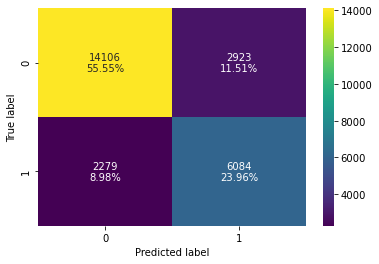

In [69]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_train2, y_train, threshold=optimal_threshold_auc_roc)

In [70]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg2, X_train2, y_train, threshold=optimal_threshold_auc_roc)

print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.73,0.68,0.70


- With this optimal threshold the precision score decreased, but, more importantly, both the recall and F1 scores improved.
- Therefore, the model with this threshold is more useful for INN Hotel's intended use case.

### Optimal threshold using the Precision-Recall curve

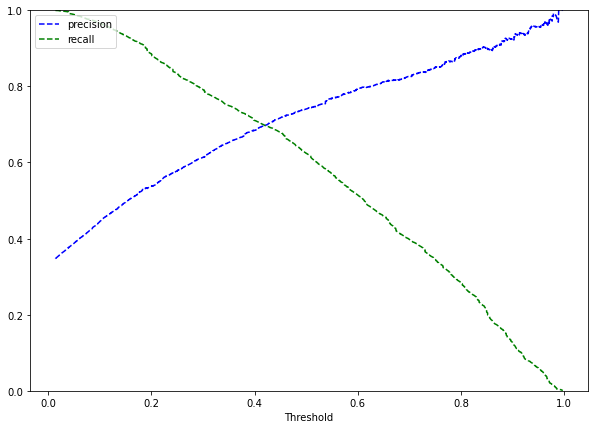

In [71]:
y_scores = lg2.predict(X_train2)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At the threshold of approximately 0.42, we reach a balance of recall and precision scores.

In [72]:
# setting the threshold
optimal_threshold_curve = 0.42

#### Checking model performance on training set

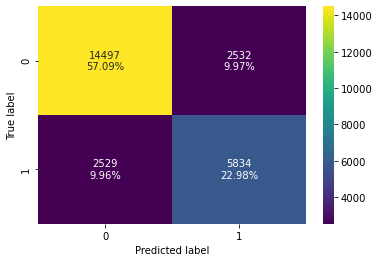

In [73]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_train2, y_train, threshold=optimal_threshold_curve)

In [74]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(
    lg2, X_train2, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.70,0.70,0.70


* Model is performing well on training set.
* There's not much improvement in the model performance as the default threshold is 0.50 and here we get 0.58 as the optimal threshold.

### Model performance summary

In [75]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.38 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.38 Threshold,Logistic Regression-0.42 Threshold
Accuracy,0.80,0.80,0.80
Recall,0.62,0.73,0.70
Precision,0.74,0.68,0.70
F1,0.68,0.70,0.70


### Check model performance on the test set

In [76]:
#dropping the columns from the test set that were dropped from the training set
X_test2 = X_test[list(X_train2.columns)]

**Using model with default threshold**

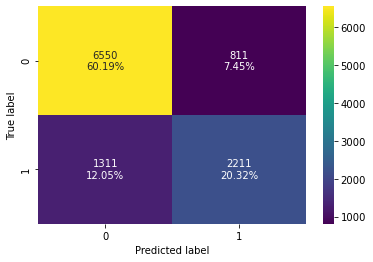

In [77]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_test2, y_test)

In [78]:
log_reg_model_test_perf = model_performance_classification_statsmodels(lg2, X_test2, y_test)

print("Test performance:")
log_reg_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.81,0.63,0.73,0.68


* ROC curve on test set

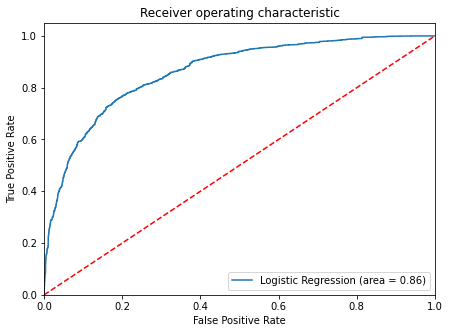

In [79]:
logit_roc_auc_train = roc_auc_score(y_test, lg2.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test, lg2.predict(X_test2))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Using model with threshold=0.38** 

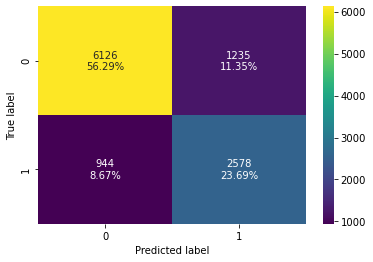

In [80]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_test2, y_test, threshold=optimal_threshold_auc_roc)

In [81]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg2, X_test2, y_test, threshold=optimal_threshold_auc_roc
)
print("Test performance:")
log_reg_model_test_perf_threshold_auc_roc

Test performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.73,0.68,0.70


**Using model with threshold = 0.42**

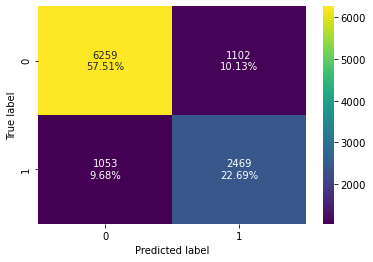

In [82]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_test2, y_test, threshold=optimal_threshold_curve)

In [83]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_statsmodels(
    lg2, X_test2, y_test, threshold=optimal_threshold_curve
)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


,Accuracy,Recall,Precision,F1
0,0.80,0.70,0.69,0.70


## Logistic Regression model summary

In [84]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.38 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.38 Threshold,Logistic Regression-0.42 Threshold
Accuracy,0.80,0.80,0.80
Recall,0.62,0.73,0.70
Precision,0.74,0.68,0.70
F1,0.68,0.70,0.70


In [85]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.38 Threshold",
    "Logistic Regression-0.42 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.38 Threshold,Logistic Regression-0.42 Threshold
Accuracy,0.81,0.80,0.80
Recall,0.63,0.73,0.70
Precision,0.73,0.68,0.69
F1,0.68,0.70,0.70


### Conclusions
* We were able to build a predictive model that can be used by INN Hotels to predict which bookings will be canceled with an F1 score of 0.70 on the training set.

* All the logistic regression models have given a generalized performance on both the training and test set, indicating this model should perform similarly for INN Hotels in production.

* Coefficients for the number of adults, the lead time prior to a booking, the arrival year (i.e., 2018 v. 2017), the number of previous cancellations, the average room price, the total nights booked, selecting Meal Plan 2, and not selecting a meal plan are all positive, meaning an increase in these will lead to increase in chances of a hotel booking being cancelled.

* Coefficients for requiring a parking space, arrival month, being a repeat guest, the number of special requests, and the market segments for Corporate and Offline are all negative, meaning an increase in these will lead to decrease in chances of a hotel booking being cancelled.

# Decision Tree models

In [86]:
#resplit data for the decision tree model
X = df.drop(["booking_status"], axis=1)
Y = df["booking_status"]

#create dummy variables
X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

In [87]:
X_train.head()

,no_of_adults,no_of_children,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,total_nights,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
13662,1,0,0,163,2018,10,15,0,0,0,115.00,0,1,0,0,0,0,0,1,0
26641,2,0,0,113,2018,3,31,0,0,0,78.15,1,3,0,0,0,0,0,0,1
17835,2,0,0,359,2018,10,14,0,0,0,78.00,1,5,0,0,0,0,0,1,0
21485,2,0,0,136,2018,6,29,0,0,0,85.50,0,3,0,0,1,0,0,0,1
5670,2,0,0,21,2018,8,15,0,0,0,151.00,0,3,0,0,0,0,0,0,1


We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. Other option include 'entropy'.  

In [88]:
#confirm percentage of each class in both training and test datasets
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
0   0.67
1   0.33
Name: booking_status, dtype: float64
 
Percentage of classes in test set:
0   0.68
1   0.32
Name: booking_status, dtype: float64


### Model evaluation criterion for the Decision Tree Model is the same as specified above for the Logistic Regression Model (i.e., maximize F1 score)

## Building a Decision Tree model

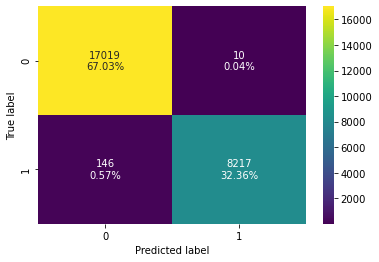

In [89]:
#build the decision tree model
dtree = DecisionTreeClassifier(criterion="gini", class_weight={0: 0.67, 1: 0.33}, random_state=1)
#fit the model to the training set
dtree.fit(X_train, y_train)
#create a confusion matrix
confusion_matrix_sklearn(dtree, X_train, y_train)

In [90]:
decision_tree_perf_train = get_f1_score(dtree, X_train, y_train)

print("F1 Score:", decision_tree_perf_train)

F1 Score: 0.9905967450271249


* As shown above, the model is only misclassifies 156 bookings on the training set, but this model is most likely significantly overfit for the training data.

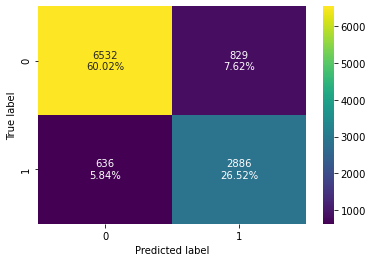

In [91]:
#create a confusion matrix for the test set
confusion_matrix_sklearn(dtree, X_test, y_test)

In [92]:
decision_tree_perf_test = get_f1_score(dtree, X_test, y_test)
print("F1 Score:", decision_tree_perf_test)

F1 Score: 0.7975680530606605


* There is a significant difference in the performance of the model on the training set and the test set, which suggests that the model is overfiiting.

#### Visualizing the Decision Tree

In [93]:
## creating a list of column names
feature_names = X_train.columns.to_list()

In [94]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dtree, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- avg_price_per_room <= 201.50
|   |   |   |   |   |--- total_nights <= 5.50
|   |   |   |   |   |   |--- lead_time <= 74.50
|   |   |   |   |   |   |   |--- arrival_month <= 5.50
|   |   |   |   |   |   |   |   |--- arrival_date <= 27.50
|   |   |   |   |   |   |   |   |   |--- lead_time <= 59.50
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Offline <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Offline >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |--- lead_time >  59.50
|   |   |   |   |   |   |   |   |   |   |--- avg_price_per_room <= 138.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   

* The tree above is very complex and difficult to interpret.

In [95]:
#Print the top-10 most important features in the decision tree 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature

print(pd.DataFrame(dtree.feature_importances_, columns=["Imp"], index=X_train.columns).sort_values(
    by="Imp", ascending=False).head(n=10))

                                Imp
lead_time                      0.34
avg_price_per_room             0.22
arrival_date                   0.10
market_segment_type_Online     0.08
arrival_month                  0.07
total_nights                   0.06
no_of_special_requests         0.05
no_of_adults                   0.03
type_of_meal_plan_Not Selected 0.01
arrival_year                   0.01


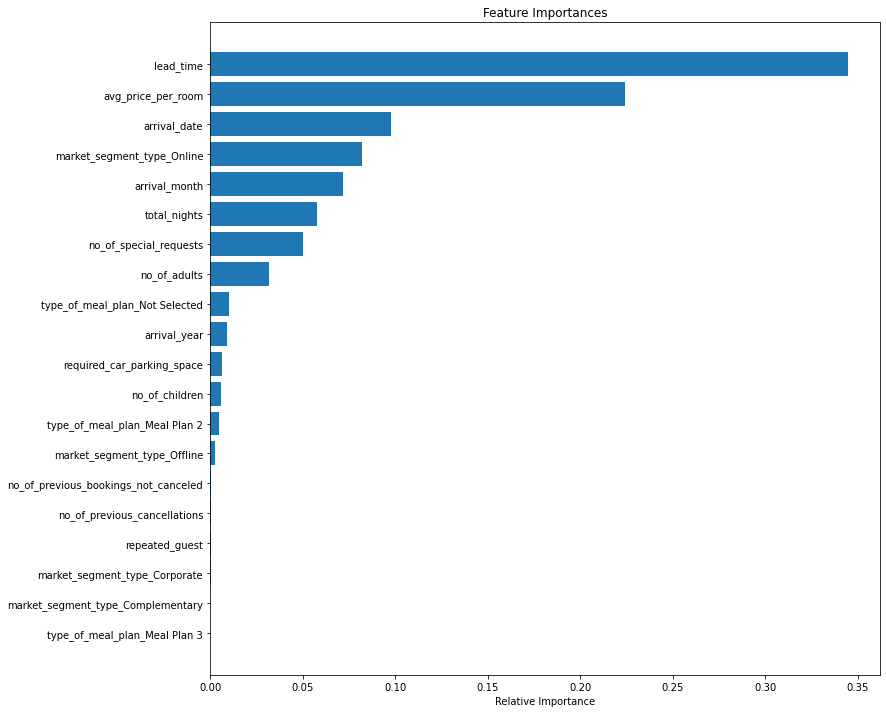

In [96]:
#visualization of feature importance
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* According to the decision tree model, *lead_time* and *avg_price_per_room* are the two most important variables for predicting a booking's cancellation by a factor of 3 and 2, respectively, over the third most important variable, *arrival_date*.

## Decision Tree pruning

### GridSearch for hyperparameter tuning

* Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
* The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [97]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight={0: 0.67, 1: 0.33})

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.67, 1: 0.33},
                       min_impurity_decrease=1e-05, random_state=1)

#### Checking performance on training set

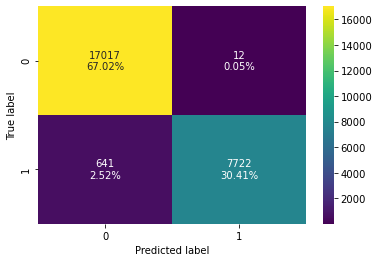

In [98]:
confusion_matrix_sklearn(estimator, X_train, y_train)

In [99]:
decision_tree_tune_perf_train = get_f1_score(estimator, X_train, y_train)
print("F1 Score:", decision_tree_tune_perf_train)

F1 Score: 0.9594334348015158


#### Checking performance on test set

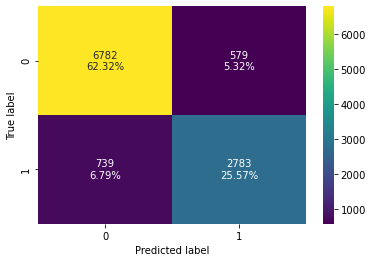

In [100]:
confusion_matrix_sklearn(estimator, X_test, y_test)

In [101]:
decision_tree_tune_perf_test = get_f1_score(estimator, X_test, y_test)
print("F1 Score:", decision_tree_tune_perf_test)

F1 Score: 0.8085415456130156


* The model is performing slightly better, but still appears overfitted to the training data

#### Visualizing the Decision Tree

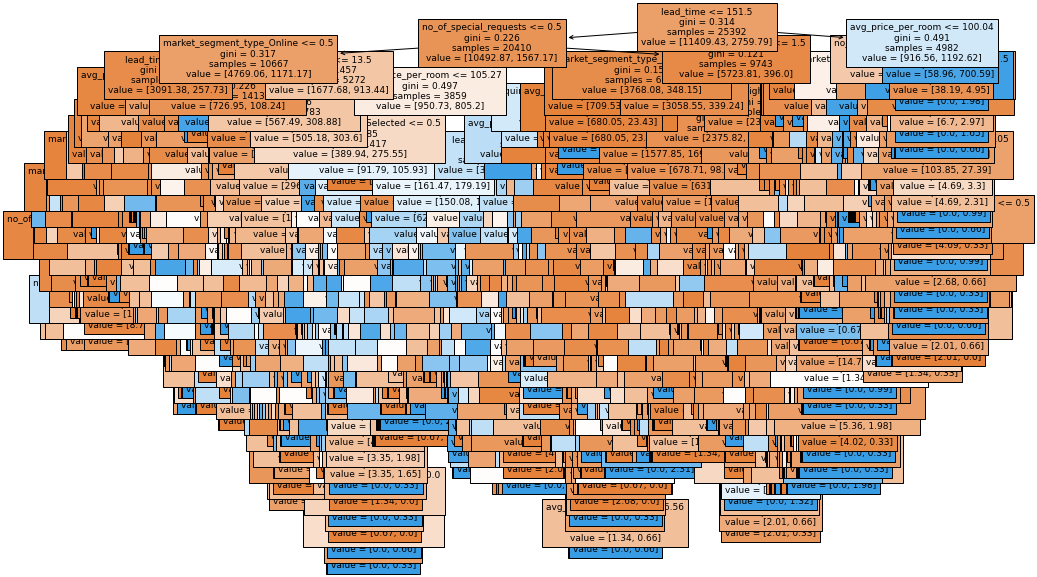

In [102]:
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

* The tree above is still very complex and difficult to interpret.

In [103]:
#Print the top-10 most important features in the decision tree 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature

print(pd.DataFrame(estimator.feature_importances_, columns=["Imp"], index=X_train.columns).sort_values(
    by="Imp", ascending=False).head(n=10))

                                Imp
lead_time                      0.35
avg_price_per_room             0.22
arrival_date                   0.09
market_segment_type_Online     0.09
arrival_month                  0.07
total_nights                   0.05
no_of_special_requests         0.05
no_of_adults                   0.03
arrival_year                   0.01
type_of_meal_plan_Not Selected 0.01


* According to this pre-pruned decision tree model, *lead_time* and *avg_price_per_room* are still the two most important variables for predicting a booking's cancellation by a factor of 3 and 2, respectively, over the third most important variable, *arrival_date*.

### Cost Complexity Pruning
Minimal cost complexity pruning recursively finds the node with the "weakest link". The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of *ccp_alpha* could be appropriate, scikit-learn provides *DecisionTreeClassifier.cost_complexity_pruning_path* that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [104]:
clf = DecisionTreeClassifier(random_state=1, class_weight={0: 0.67, 1: 0.33})
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [105]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.00,0.01
1,0.00,0.01
2,0.00,0.01
3,0.00,0.01
4,0.00,0.01
...,...,...
1589,0.01,0.21
1590,0.01,0.22
1591,0.01,0.24
1592,0.02,0.27


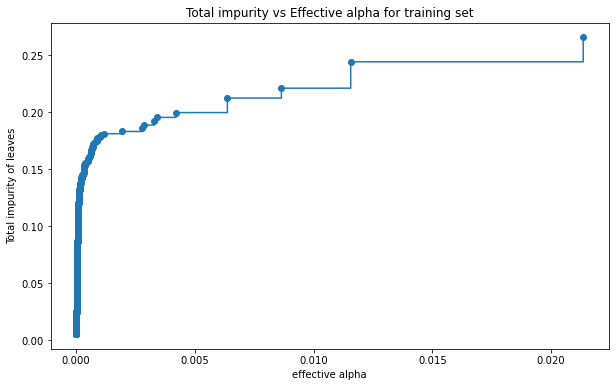

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs Effective alpha for training set")
plt.show()

Next, we train a decision tree using the effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.

In [107]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha, class_weight={0: 0.67, 1: 0.33})
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.04805816398780094



For the remainder, we remove the last element in
``clfs`` and ``ccp_alphas``, because it is the trivial tree with only one
node. Here we show that the number of nodes and tree depth decreases as alpha
increases.

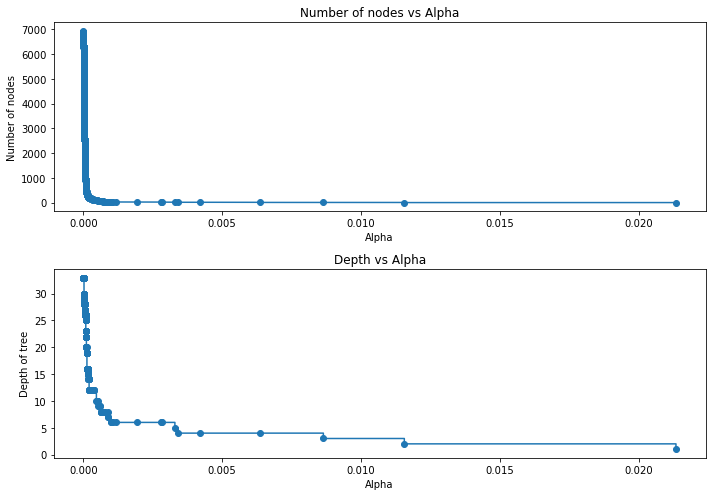

In [108]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs Alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of tree")
ax[1].set_title("Depth vs Alpha")
fig.tight_layout()

In [109]:
f1_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = f1_score(y_train, pred_train)
    f1_train.append(values_train)

In [110]:
f1_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = f1_score(y_test, pred_test)
    f1_test.append(values_test)

In [111]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

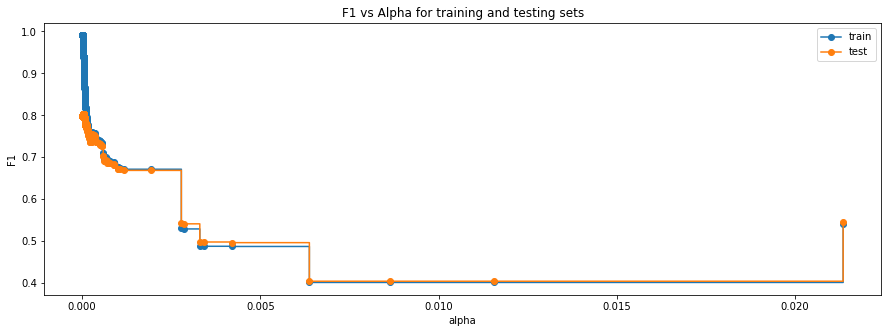

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("F1")
ax.set_title("F1 vs Alpha for training and testing sets")
ax.plot(
    ccp_alphas, f1_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, f1_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [113]:
#create the model where we get highest train and test recall
index_post = np.argmax(f1_test)
dtree_post = clfs[index_post]
print(dtree_post)

DecisionTreeClassifier(ccp_alpha=2.9139582423140346e-05,
                       class_weight={0: 0.67, 1: 0.33}, random_state=1)


In [114]:
dtree_post.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=2.9139582423140346e-05,
                       class_weight={0: 0.67, 1: 0.33}, random_state=1)

#### Checking performance on training set

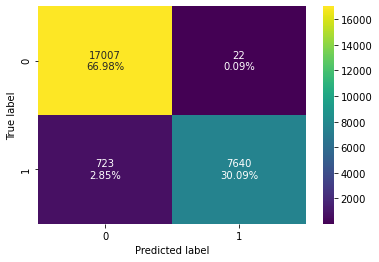

In [115]:
confusion_matrix_sklearn(dtree_post, X_train, y_train)

In [116]:
decision_tree_postpruned_perf_train = get_f1_score(dtree_post, X_train, y_train)
print("F1 Score:", decision_tree_postpruned_perf_train)

F1 Score: 0.9535101404056163


#### Checking performance on the test set

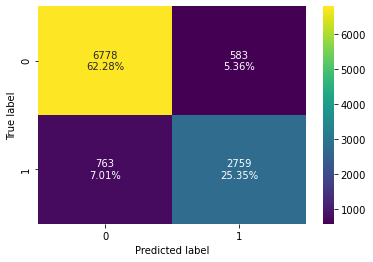

In [117]:
confusion_matrix_sklearn(dtree_post, X_test, y_test)

In [118]:
decision_tree_postpruned_perf_test = get_f1_score(dtree_post, X_test, y_test)
print("F1 Score:", decision_tree_postpruned_perf_test)

F1 Score: 0.8039044289044289


#### Visualizing the Decision Tree

In [119]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dtree_post, feature_names=feature_names, show_weights=True))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type_Online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- avg_price_per_room <= 201.50
|   |   |   |   |   |--- total_nights <= 5.50
|   |   |   |   |   |   |--- lead_time <= 74.50
|   |   |   |   |   |   |   |--- arrival_month <= 5.50
|   |   |   |   |   |   |   |   |--- arrival_date <= 27.50
|   |   |   |   |   |   |   |   |   |--- lead_time <= 59.50
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Offline <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- market_segment_type_Offline >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [344.38, 3.63] class: 0
|   |   |   |   |   |   |   |   |   |--- lead_time >  59.50
|   |   |   |   |   |   |   |   |   |   |--- avg_price_per_room <= 138.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|

* The tree above is still complex and difficult to interpret.

In [120]:
#Print the top-10 most important features in the decision tree 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature

print(pd.DataFrame(dtree_post.feature_importances_, columns=["Imp"], index=X_train.columns).sort_values(
    by="Imp", ascending=False).head(n=10))

                                Imp
lead_time                      0.35
avg_price_per_room             0.22
market_segment_type_Online     0.09
arrival_date                   0.09
arrival_month                  0.07
no_of_special_requests         0.05
total_nights                   0.05
no_of_adults                   0.03
type_of_meal_plan_Not Selected 0.01
arrival_year                   0.01


* According to this post-pruned decision tree model, *lead_time* and *avg_price_per_room* are still the two most important variables for predicting a booking's cancellation by a factor of 3.5 and 2, respectively, over the third most important variable, *arrival_date*.

### GridSearch for hyperparameter tuning (Optimal depth)

Assume that INN Hotels requests a model which can be followed more easily than these complex models, thereby allowing them to justify its predictions in retrospect. Ideally, the decision-tree model should have a higher F1 score than the best logistic regression model (0.70), while providing a simpler tree.

In [121]:
# Choose the type of classifier.
easy_read = DecisionTreeClassifier(random_state=1, class_weight={0: 0.67, 1: 0.33})

# Grid of parameters to choose from
parameters = {
    "max_depth": [2,4,6,8],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(easy_read, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
easy_read = grid_obj.best_estimator_

# Fit the best algorithm to the data.
easy_read.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.67, 1: 0.33}, max_depth=8,
                       min_impurity_decrease=1e-05, random_state=1)

#### Visualizing the decision-tree

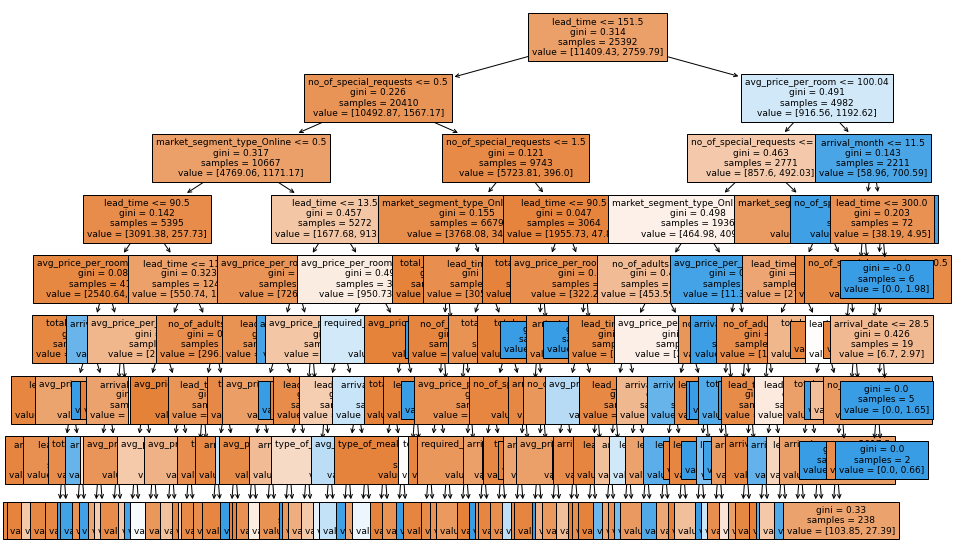

In [122]:
plt.figure(figsize=(15, 10))
out = tree.plot_tree(
    easy_read,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

* The decision-tree is definitely less complex and easier to follow than the pre-pruned tree above.

#### Checking performance on the training set

In [123]:
decision_tree_tune_perf_train_easy = get_f1_score(easy_read, X_train, y_train)
print("F1 Score:", decision_tree_tune_perf_train_easy)

F1 Score: 0.7470162124870645


#### Checking performance on the test set

In [124]:
decision_tree_tune_perf_test_easy = get_f1_score(easy_read, X_test, y_test)
print("F1 Score:", decision_tree_tune_perf_test_easy)

F1 Score: 0.7379941195687684


* The model has a better F1 score on both the training and testing datasets than the logistic regression models.
* Additionally, this simpler model appears to perform similarly well on both the training and test dataset, indicating that this model is not overfit to the training data and thereby should provide more generalizable predictions.

#### Feature importance

In [125]:
#Print the top-10 most important features in the decision tree 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature

print(pd.DataFrame(easy_read.feature_importances_, columns=["Imp"], index=X_train.columns).sort_values(
    by="Imp", ascending=False).head(n=10))

                                Imp
lead_time                      0.41
avg_price_per_room             0.22
market_segment_type_Online     0.15
no_of_special_requests         0.09
arrival_month                  0.05
no_of_adults                   0.03
total_nights                   0.02
required_car_parking_space     0.01
arrival_date                   0.01
type_of_meal_plan_Not Selected 0.00


* According to this less complex decision tree model, *lead_time* and *avg_price_per_room* are again the two most important variables, while *market_segment_type_Online* has also increased in importance over previous trees.

### Comparing all the decision tree models

In [126]:
# training performance comparison

models_train_comp_df = pd.DataFrame(
    [
        decision_tree_perf_train,
        decision_tree_tune_perf_train,
        decision_tree_postpruned_perf_train,
        decision_tree_tune_perf_train_easy
    ],
    columns=["F1"],
    index=[['Decision-Tree','Pre-Pruned Tree','Post-Pruned Tree','Readible Tree']]
)

print("Training performance comparison:")
models_train_comp_df.T

Training performance comparison:


,Decision-Tree,Pre-Pruned Tree,Post-Pruned Tree,Readible Tree
F1,0.99,0.96,0.95,0.75


In [127]:
# testing performance comparison

models_test_comp_df = pd.DataFrame(
    [
        decision_tree_perf_test,
        decision_tree_tune_perf_test,
        decision_tree_postpruned_perf_test,
        decision_tree_tune_perf_train_easy
    ],
    columns=["F1"], 
    index=[['Decision-Tree','Pre-Pruned Tree','Post-Pruned Tree', 'Readible Tree']]
)

print("Test performance comparison:")
models_test_comp_df.T

Test performance comparison:


,Decision-Tree,Pre-Pruned Tree,Post-Pruned Tree,Readible Tree
F1,0.80,0.81,0.80,0.75


# Conclusions
- We analyzed the cancelation decisions of 36,275 bookings through four different Decision Tree classifiers to create a predictive model for the same. These models can be used by INN Hotels Group to predict if a booking will be canceled prior to the check-in date.
- All four of the decision-tree models perform better, via our objective criterion of F1 score, than best-performing logistic regression model.
- We visualized each model's decision-tree and confusion matrix to get a better understanding of each model. However, the predictions from the original, pre-pruned, and post-pruned decision-tree model would be difficult to interpret by the client. For example, observe the substantial complexity of the pre-pruned decision-tree in its visualization above.
- Despite our efforts to tune the decision-tree model in order to reduce overfitting, both pre-pruning and post-pruning methods resulted in minimal reductions to overfitting. However, the best performing model, the pre-pruned decision-tree, still shows a significant disparity between its performance on the training dataset and the test dataset. This indicates that this model's predictions, as compared to the best logistic regression model, may not be as generalizable.
- INN Hotels should consider the tradeoff that exists for these decision-tree models with respect to performance, overfitting, and understanding the decision-making criteria of the model. 
    - If a more understandable prediction model is the objective, then the minimal depth required for this decision-tree model to perform better than the best logistic regression model, is 8. However, if the tree above is still too complex for the client's use-case and preferences, than potentially the logistic regression model is the ideal prediction tool.
    - Alternatively, if INN Hotels is seeking the best performing prediction model and is also comfortable with these predictions originating from a "black-box" model, then the pre-pruned tree provides that.
- Across all four models, *lead_time* and *avg_price_per_room* were the two most important variables for predicting a booking's cancellation.

# Actionable Insights and Recommendations

- Our EDA and predictions from both models show that guests booking cheaper rooms, with shorter lead times, requiring a parking space, being a repeat guest, with higher number of special requests, from the Corporate and Offline market segments are less likely to cancel bookings. Conversely, guests booking more expensive rooms, with longer lead times, through the Online market segment are more likely to cancel bookings.

**What profitable policies for cancellations and refunds can the hotel adopt?**
- Based on the coefficients in the logistic regression models and the features in the decision-tree models, both prediction models provide evidence that INN Hotels should at least consider separate cancellation and refund policies for its guests travelling for business or personal reasons.
- Therefore, the data suggests that introducing a rewards program for business travelers (e.g., requiring more frequent trips, booking on short notice from a corporate sales channel, and directed by corporate travel guidelines to book a room with the lowest available cost) should further incentive these guests to book at INN Hotels and follow-through on their travel plans.
- Additionally, in case a hotel is at capacity or overbooked, management could utilize the model to ensure all repeat guests or guests travelling for business reasons have rooms available. Conversely, management can combine predictions from both models to identify the "most likely case" that a booking will be canceled and reallocate that room to a booking for that room category which is the "least likely case".
     - We offer a disclaimer that this model should not replace the industry experience of its management team regarding managing its hotel's capacity. Rather, these models can provide supplemental evidence in support of its decision-making process.

**What other recommedations would you suggest to the hotel?**
- To further improve the utility of the models, the hotel can provide approximations of the costs related to the outcomes corresponding to true/false positives/negatives. Our team can then optimize the models predicitions to achieve the highest expected profits, versus optimizing for F1 score, which we chose for our evaluation criteria based on the client's use-case.